# 1-D Heat Flow

This notebook provide a demo case on the application of the heat conduction solver.
The numerical solver is discretised in time and space.  The solver uses backward Euler centered differencing with Newton iteration.

The heatConduction package contains necessary components to solve the PDEs. To just use it as a solver, simply passing the generated parameters to the solve function and execute. <br>
The solution process will be displayed as, time step, physical time, number of Newton's iteration and residual.

The `preprocess()` function transform the results  numpy array into a Pandas DataFrame, with index as grid locations and columns as timings.

In [52]:
# try:
#     import cupy as np                    
# except ImportError:
import numpy as np
import pandas as pd

import pyradi.ryplot as ryplot
from matplotlib import cm
    
import heatConduction as hc
import postprocessing as pp

In [53]:
def processplot(T,paras,deciX=1,deciT=5):
    npos = int(paras['numberOfNode']/10) if paras['numberOfNode'] > 10 else 1
    positions = T.index[::npos]
    deltaL = paras['length']/(paras['numberOfNode'] -1)
    
    filenamea = f"{paras['material']}-L{paras['length']:.2f}-N{paras['numberOfNode']:.0f}"
    filenameb = f"-T{totalTime:.0f}-S{paras['Solar constant']:.0f}"
    filenamec = f"-E{paras['Emissivity']:.2f}-A{paras['AtmoTau']:.2f}-W{paras['WindSpeed']:.1f}-Lc{paras['ConvLCrit']:.3f}"
    filename = f"{filenamea}{filenameb}{filenamec}".replace(' ','').replace('%','').replace('.','p')
    print(filename)
    scenarioa = f"Sun={paras['Solar constant']:.0f} W/m2, es={paras['Emissivity']:.2f}, tauA={paras['AtmoTau']:.2f}, "
    scenariob = f"Wind={paras['WindSpeed']:.0f} m/s, Lcrit={paras['ConvLCrit']:.3f} m, "
    scenarioc = f"N={paras['numberOfNode']:.0f}, $\Delta$L={deltaL:0.3f} m, $\Delta$t={paras['deltaTime']:.2f} s"
    scenario = f"{scenarioa}{scenariob}{scenarioc}"
    print(scenario)
    pp.plotsummary(T, positions,deciX,deciT,f"{scenario}", f'{filename}.png')



## Steel

### Stationary boundary condition

This is the reference calculation, to be the same as the original case.

Set up the parameters into a pandas series

A single  emissivity value serves for both radiative loss and solar irradiance.

The atmospheric transmittance accounts for the mean atmospheric transmittance for a slant path to space.

The solar constant is the flux density at the top of the atmosphere.

In [3]:
column = 'values'
paras = pd.Series(name = column,dtype='object')
# paras = paras.astype('object')

# Grid
paras['length'] = 0.05
paras['numberOfNode'] = 501


# Material
paras['material'] = 'Steel'
paras['density'] = 7850        #  kg/m3
paras['conductivity'] = 60.5   #  W/(m.K)
paras['heatCapacity cp'] = 434    #  J/(kg.K)
paras['diffusivity'] = paras['conductivity'] / (paras['density'] * paras['heatCapacity cp']) # m2/s
paras['penDepth (Diurnal)'] = np.sqrt(7.7 * paras['diffusivity'] * 86.4e3 )

# Solution
paras['numberOfTimeStep'] = 50 
paras['deltaTime'] = 0.2
paras['maxIteration'] = 20
paras['convergence'] = 1E-10
paras['relaxation'] = 1 # value in [0-1] Very sensitive!!!
paras['showProg'] = False # print every time step
paras['penDepth'] = np.sqrt(7.7 * paras['diffusivity'] * paras['deltaTime'] )


# Initial conditions
paras['Initial value'] = 298.  # K

# Radiometry
paras['Do radiative'] = False
paras['Emissivity'] = 0.8
paras['AtmoTau'] = 0.4
paras['AtmoTemp'] = 298
paras['Do convection'] = True
paras['WindSpeed'] = 0
paras['ConvLCrit'] = 1
paras['Solar constant'] = 1367 # W/m2 top of atmo

# Boundary conditions
x0 = np.linspace(0,75000,int(paras['numberOfTimeStep']))
valueX0 = 750000 * np.ones(x0.shape)
valueXL = 0 * np.ones(x0.shape)
paras['x=0 type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=0 value'] = valueX0 
paras['x=L type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=L value'] = valueXL

In [4]:
print(paras)

length                                                             0.05
numberOfNode                                                      501.0
material                                                          Steel
density                                                            7850
conductivity                                                       60.5
heatCapacity cp                                                     434
diffusivity                                                    0.000018
penDepth (Diurnal)                                             3.437164
numberOfTimeStep                                                     50
deltaTime                                                           0.2
maxIteration                                                         20
convergence                                                         0.0
relaxation                                                            1
showProg                                                        

The `solve()` output the results and a cache. The results is a numpy array consisting of the evolution of each time step over the domain. The cache file is a Python dictionary consists of some variables used by debugging. 


In [5]:
results, cache = hc.solve(paras)

In [6]:
T = pp.preprocess(paras,results)

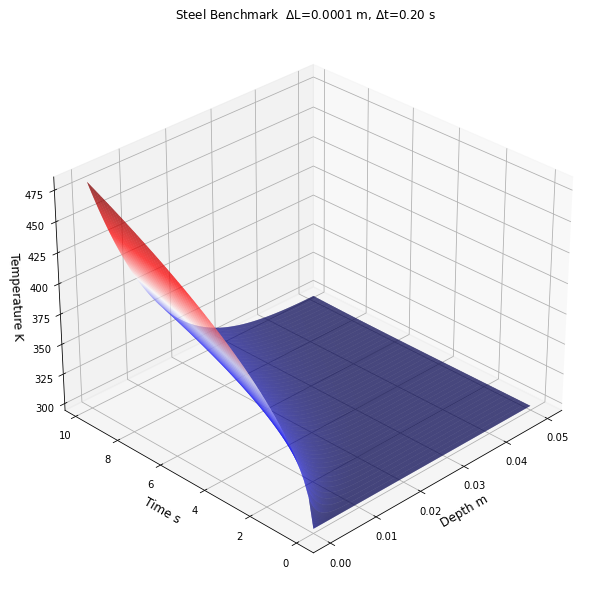

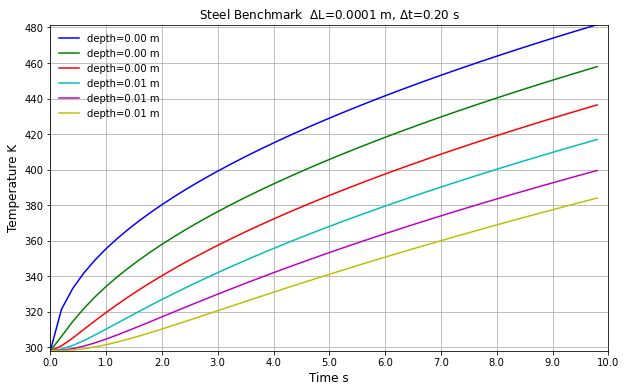

In [7]:
positions = [0, 0.002, 0.004, 0.006, 0.008, 0.01]
deltaL = paras['length']/(paras['numberOfNode'] - 1)
scenario = f'{paras["material"]} Benchmark  $\Delta$L={deltaL:0.4f} m, $\Delta$t={paras["deltaTime"]:.2f} s'
pp.plotsummary(T, positions,1,1,scenario,f'{paras["material"]}heatFEMBench.png')



The first plot is the evolution field in both time and space. We can view the results in a 3D contour plot by just passing the processed T to the function evolutionField(). <br>
It can be seen that the temperature over the var is increasing as time elapses.

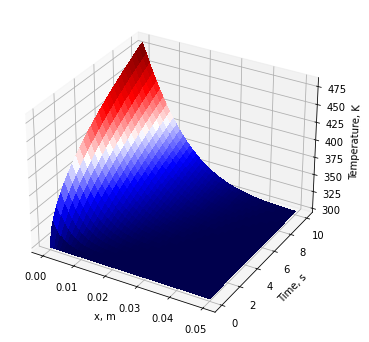

In [8]:
pp.evolutionField(T)

We can also check the temperature evolution for some specific locations, as there are thermal couples. <br>
Simply create a list of locations you want to check, and then pass the T and positions into the thermalCouplePlot() function.

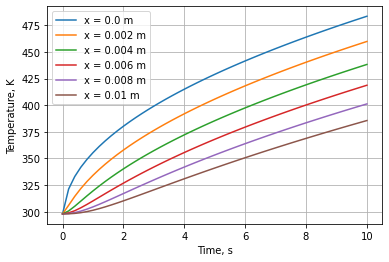

In [9]:
positions = [0, 0.002, 0.004, 0.006, 0.008, 0.01]
pp.thermalCouplePlot(T, positions)

We can futher check how the temperature is distributed over the domain at different times. Simply create a list of timings you want, and pass the T and times to the temperatureDistribution functions.

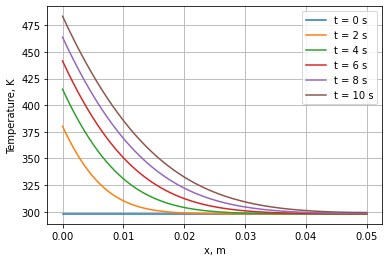

In [10]:
times = [0, 2, 4, 6, 8, 10]
pp.temperatureDistribution(T, times)

### Temporally variable boundary condition

First demo a linearly temporal-increasing input flux.



length                                                             0.05
numberOfNode                                                      501.0
material                                                          Steel
density                                                            7850
conductivity                                                       60.5
heatCapacity cp                                                     434
diffusivity                                                    0.000018
penDepth (Diurnal)                                             3.437164
numberOfTimeStep                                                     50
deltaTime                                                           0.2
maxIteration                                                         20
convergence                                                         0.0
relaxation                                                            1
showProg                                                        

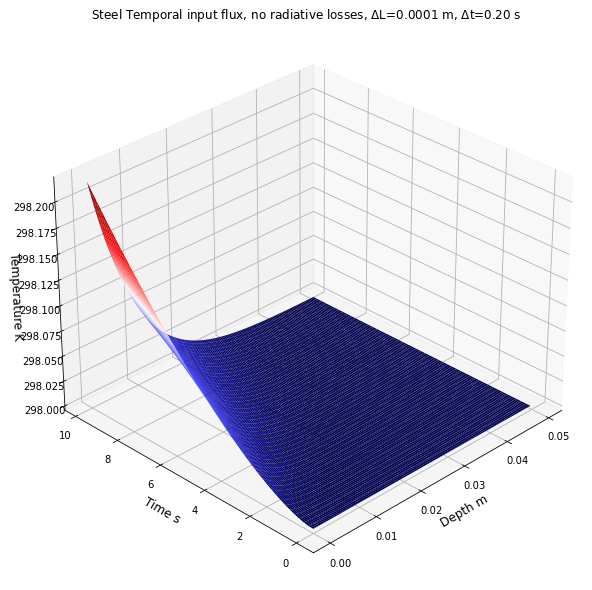

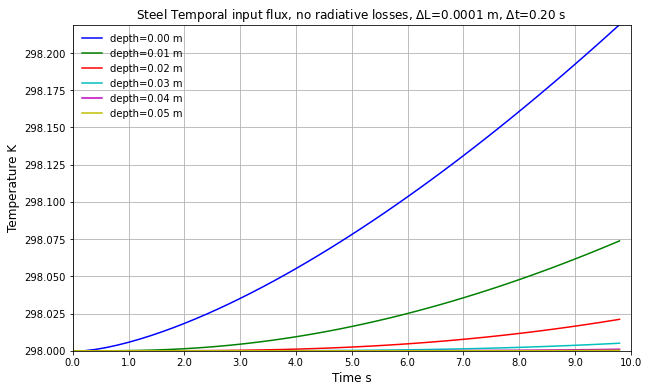

In [11]:
# Boundary conditions
x0 = np.linspace(0,paras['Solar constant'],int(paras['numberOfTimeStep']))
valueX0 = x0
valueXL = 0 * np.ones(x0.shape)
paras['x=0 type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=0 value'] = valueX0 
paras['x=L type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=L value'] = valueXL

print(paras)

results, cache = hc.solve(paras)
T = pp.preprocess(paras, results)
positions = [0, 0.01, 0.02, 0.03, 0.04, 0.05]
deltaL = paras['length']/(paras['numberOfNode'] - 1)
summ = f'{paras["material"]} Temporal input flux, no radiative losses, '
pp.plotsummary(T, positions,4,1,
    f'{summ}$\Delta$L={deltaL:0.4f} m, $\Delta$t={paras["deltaTime"]:.2f} s')


Next use positive only sine curve of input heat flux.  Negative values set to zero.

No radiative heat loss.

In this case there is only positive heat flow into the sample, with no radiative heat loss.  The temperature rises.

length                                                              0.1
numberOfNode                                                        501
material                                                          Steel
density                                                            7850
conductivity                                                       60.5
heatCapacity cp                                                     434
diffusivity                                                    0.000018
penDepth (Diurnal)                                             3.437164
numberOfTimeStep                                                   1001
deltaTime                                                           0.2
maxIteration                                                         20
convergence                                                         0.0
relaxation                                                            1
showProg                                                        

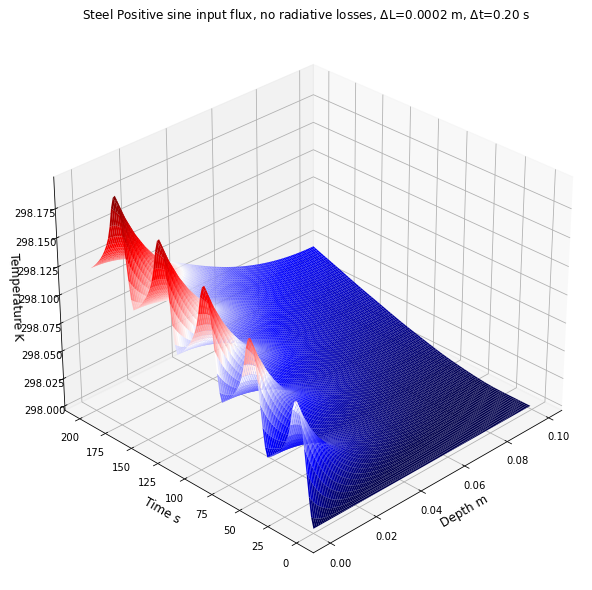

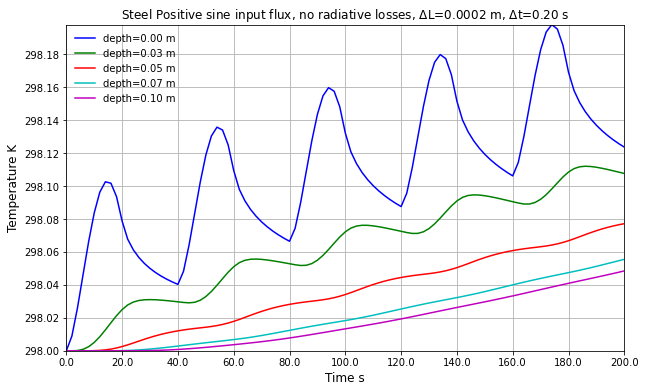

In [12]:
# Boundary conditions

# Planck radiative heat loss
paras['Do radiative'] = False

paras['numberOfTimeStep'] = 1001
paras['deltaTime'] = 0.2
paras['penDepth'] = np.sqrt(7.7 * paras['diffusivity'] * paras['deltaTime'] )

# Grid
paras['length'] = 0.1
paras['numberOfNode'] = 501

totalTime = paras['numberOfTimeStep']  * paras['deltaTime'] 
t = np.linspace(0,totalTime,int(paras['numberOfTimeStep']))
freq = 0.025
valueX0 = paras['AtmoTau'] * paras['Emissivity'] * paras['Solar constant'] * np.sin(2*np.pi*t*freq)
valueX0 = np.where(valueX0>0,valueX0,0)
valueXL = 0 * np.ones(t.shape)
paras['x=0 type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=0 value'] = valueX0 
paras['x=L type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=L value'] = valueXL

print(paras)

results, cache = hc.solve(paras)
T = pp.preprocess(paras, results)
positions = [0, 0.025, 0.05, 0.075, 0.1]
deltaL = paras['length']/(paras['numberOfNode'] - 1 )
summ = f'{paras["material"]} Positive sine input flux, no radiative losses, '
pp.plotsummary(T, positions,4,10,
    f'{summ}$\Delta$L={deltaL:0.4f} m, $\Delta$t={paras["deltaTime"]:.2f} s')


Next use positive only sine curve of input heat flux.  Negative values set to zero.

The frequency is much higher than the earth's rotation.

The radiative heat loss significantly affects the surface temperature. Without radiative loss the temperature rises by 0.6 K and with radiative loss it only rises by 0.3 K.

length                                                              0.1
numberOfNode                                                        501
material                                                          Steel
density                                                            7850
conductivity                                                       60.5
heatCapacity cp                                                     434
diffusivity                                                    0.000018
penDepth (Diurnal)                                             3.437164
numberOfTimeStep                                                   1001
deltaTime                                                           0.2
maxIteration                                                         20
convergence                                                         0.0
relaxation                                                            1
showProg                                                        

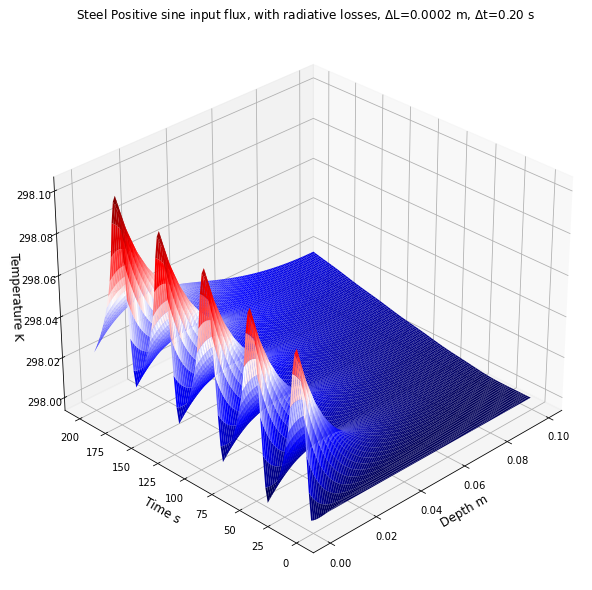

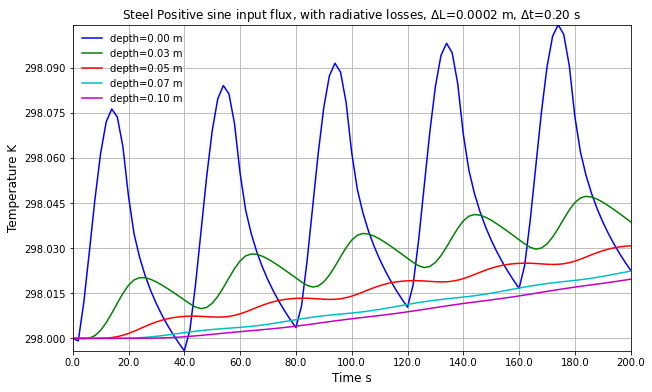

In [13]:
# Planck radiative heat loss
paras['Do radiative'] = True

print(paras)

results, cache = hc.solve(paras)
T = pp.preprocess(paras, results)

# pp.evolutionField(T)
deltaL = paras['length']/(paras['numberOfNode']  - 1)
summ = f'{paras["material"]} Positive sine input flux, with radiative losses, '
pp.plotsummary(T, positions,4,10,
    f'{summ}$\Delta$L={deltaL:0.4f} m, $\Delta$t={paras["deltaTime"]:.2f} s')

## Real world conditions

A very simple heat balance model was used on the $x=0$ boundary to investigate the effect of penetration depth and time required for stabilisation.  The model is as follows:

\begin{enumerate}

  \item Model the heat input by the positive segments (day time) of a sine wave heat flux input, negative sine wave segments (night time) were set to zero.  The magnitude of the sine wave is set to solar constant $G_\textrm{SC}$=1367~\si{\watt\per\metre\squared}, representing the flux at the top of the atmosphere.
  The solar flux absorbed into the surface is given by 
    \begin{equation}
  E_\textrm{sun}=\left\{\begin{array}{lc}
  \tau_\textrm{atmo}\,\epsilon\, G_\textrm{SC}\sin(2\pi f t)& \sin(2\pi f t)>=0\\
  0   & \sin(2\pi f t)<0
  \end{array}\right.
  \end{equation}
  
\item  Run the simulation for one or more 24 hour days, with the sine wave's frequency set to the earth's rotation.

\item Model the radiative surface heat flow (loss) by the Stefan-Boltzmann equation $E_\textrm{radloss}=\epsilon\sigma T^4$, where $\epsilon$ is the surface emissivity, $T$ is the surface temperature,  and $\sigma$ is the Stefan-BoltzmannStefan-Boltzmann constant.

\item  Model the atmospheric  irradiance  heat flow (gain) by the Stefan-Boltzmann equation $E_\textrm{atmo}=(1-\tau_\textrm{atmo})\sigma T_a^4$, assuming that the atmospheric temperature is fixed and different from the surface temperature.

\item  Convection heat loss is given by 
 \begin{equation}
E_\textrm{conv} = 
  \begin{cases}
    (T_\textrm{s} - T_a) * \max \left[\left(2.53|(T_{s}-T_{a})/L_c|^{1/3}\right) , \left(\frac{5.74 V^{0.8}}{L_c^{0.2}}\right)\right] & \textrm{Horizontal surfaces/roofs} \\
    (T_\textrm{s} - T_a) * \max \left[\left(1.69|(T_{s}-T_{a})/L_c|^{1/3}\right) , \left(\frac{4.2V^{0.78}}{L_c^{0.2}}\right)\right] & \textrm{Vertical surfaces/walls}
  \end{cases}
\end{equation}
where 
$V$ is the windspeed in m/s,
$L_c$ is the critical dimension in m,
$T_\textrm{s}$ is the surface temperature in K, and
$T_a$ is the atmospheric temperature in K.

\end{enumerate}

As long as the surface is not in thermal balance, the 24-hour average surface and inner temperature will increase or decrease until $E_\textrm{sun}+E_\textrm{radloss}+E_\textrm{atmo}$ approaches a constant value.  This solution to the heat balance equation does not solve for the surface temperature at any given moment, but rather solve for the time when the 24-hour average surface temperature will stablise. 

Experimentation not shown here indicated that it is necessary to use relatively long sample lengths, exceeding the penetration depth (Section~\ref{sec:PenetrationDepth}) given the material and the time duration. It was also found necessary to use the same material sample lengths (depths) for runs all the runs. You cannot use a short sample depth for initial work and then use longer sample depths for later work.  The heat flow and storage depends on the physical size of the object. All subsequent work was done for material sample lengths of 6~\si{\metre}.


### Unknown Temperature 

Suppose the solid initial temperature is not known. In this case it is assumed to be 298~\si{\kelvin}. 
The simulation is allowed to run until the average temperature is more or less stable.
This stability is not determined mathematically, only by inspection.
In this case the temperature stablises at  307.8~\si{\kelvin}, increasing by approximately 10~\si{\kelvin},  after about 60 or 70 days.
It is evident that a reasonably close estimate of the temperature must be available.


The graph below shows that at a depth of 6~\si{\metre} the temperature still varies after all this time.

length                                                              6.0
numberOfNode                                                        601
material                                                          Steel
density                                                            7850
conductivity                                                       60.5
heatCapacity cp                                                     434
diffusivity                                                    0.000018
penDepth (Diurnal)                                             3.437164
numberOfTimeStep                                                  43200
deltaTime                                                           600
maxIteration                                                         20
convergence                                                         0.0
relaxation                                                            1
showProg                                                        

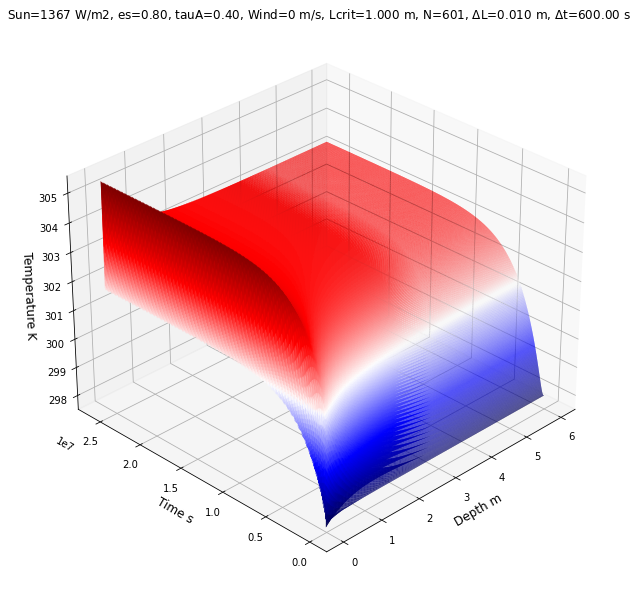

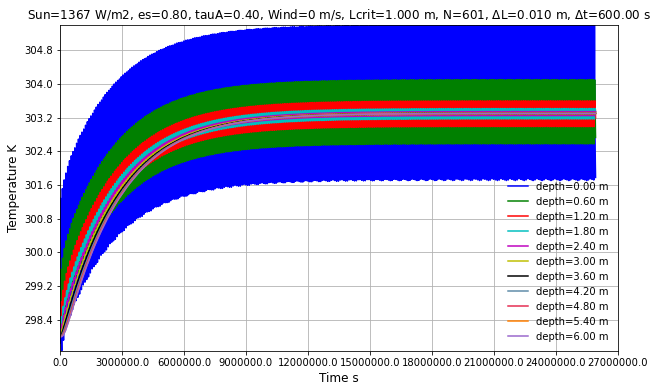

In [14]:


# Planck radiative heat loss
paras['Do radiative'] = True

# Grid
paras['length'] = 6.
paras['numberOfNode'] = 601

# time
numberDays = 300
freq =  1 / (60 * 60 * 24)
paras['numberOfTimeStep'] = numberDays * 144
paras['deltaTime'] = 600
paras['penDepth'] = np.sqrt(7.7 * paras['diffusivity'] * paras['deltaTime'] )

totalTime = paras['numberOfTimeStep']  * paras['deltaTime'] 
t = np.linspace(0,totalTime,int(paras['numberOfTimeStep']))

valueX0 = paras['AtmoTau'] * paras['Emissivity'] * paras['Solar constant'] * np.sin(2*np.pi*t*freq)
valueX0 = np.where(valueX0>0,valueX0,0)
valueXL = 0 * np.ones(t.shape)
paras['x=0 type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=0 value'] = valueX0 
paras['x=L type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=L value'] = valueXL

print(paras)

results, cache = hc.solve(paras)

T = pp.preprocess(paras, results)

processplot(T,paras,deciX=2,deciT=5)


The next experiment uses the average temperature of the last 24 hour period in the run shown above.


length                                                              6.0
numberOfNode                                                        601
material                                                          Steel
density                                                            7850
conductivity                                                       60.5
heatCapacity cp                                                     434
diffusivity                                                    0.000018
penDepth (Diurnal)                                             3.437164
numberOfTimeStep                                                   8640
deltaTime                                                            60
maxIteration                                                         20
convergence                                                         0.0
relaxation                                                            1
showProg                                                        

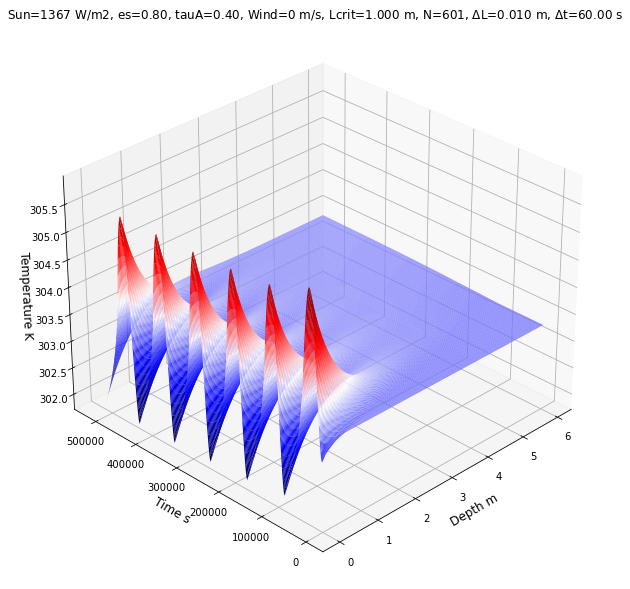

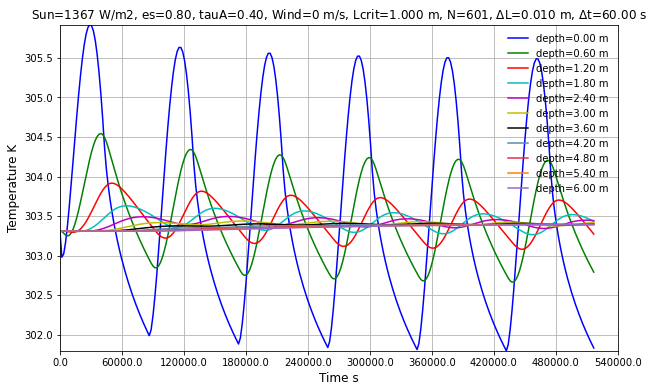

In [15]:

# get surface temperature in last 24 hours
paras['Initial value'] = T.values[0,-144:-1].mean()  # K

# time
numberDays = 6
freq =  1 / (60 * 60 * 24)
paras['numberOfTimeStep'] = numberDays * 1440
paras['deltaTime'] = 60
paras['penDepth'] = np.sqrt(7.7 * paras['diffusivity'] * paras['deltaTime'] )

totalTime = paras['numberOfTimeStep']  * paras['deltaTime'] 
t = np.linspace(0,totalTime,int(paras['numberOfTimeStep']))

valueX0 = paras['AtmoTau'] * paras['Emissivity'] * paras['Solar constant'] * np.sin(2*np.pi*t*freq)
valueX0 = np.where(valueX0>0,valueX0,0)
valueXL = 0 * np.ones(t.shape)
paras['x=0 type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=0 value'] = valueX0 
paras['x=L type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=L value'] = valueXL

print(paras)

results, cache = hc.solve(paras)

T = pp.preprocess(paras, results)


processplot(T,paras,deciX=3,deciT=30)


## Soil

Soil diffusivity ranges from \num{0.1-6} to \num{1-6} \si{metre\squared\per\second} (for peat and sandy soil). 

In [16]:

# Sand
paras['material'] = 'Sand 20% water'
paras['density'] = 1800        #  kg/m3
paras['conductivity'] = 1.8   #  W/(m.K)
paras['heatCapacity cv'] = 1.2e6    #  J/(m3.K)
paras['heatCapacity cp'] = paras['heatCapacity cv']/paras['density']     #  J/(kg.K)
paras['diffusivity'] = paras['conductivity'] / (paras['density'] * paras['heatCapacity cp']) # m2/s
paras['penDepth (Diurnal)'] = np.sqrt(7.7 * paras['diffusivity'] * 86.4e3 )

Sand20water-L3p00-N301-T8640000-S1367-E0p80-A0p40-W0p0-Lc1p000
Sun=1367 W/m2, es=0.80, tauA=0.40, Wind=0 m/s, Lcrit=1.000 m, N=301, $\Delta$L=0.010 m, $\Delta$t=600.00 s
length                                                              3.0
numberOfNode                                                        301
material                                                 Sand 20% water
density                                                            1800
conductivity                                                        1.8
heatCapacity cp                                              666.666667
diffusivity                                                    0.000002
penDepth (Diurnal)                                             0.998959
numberOfTimeStep                                                  14400
deltaTime                                                           600
maxIteration                                                         20
convergence                           

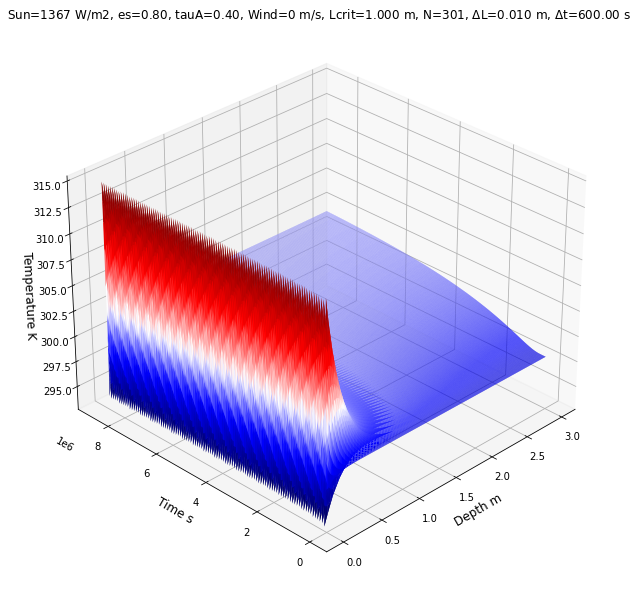

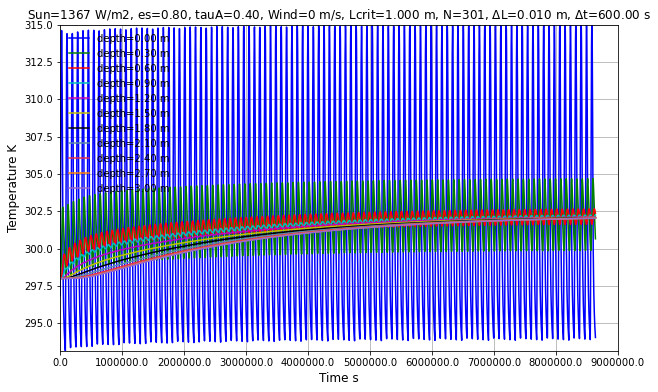

In [17]:
# Planck radiative heat loss
paras['Do radiative'] = True

# Grid
paras['length'] = 3.
paras['numberOfNode'] = 301

# Initial conditions
paras['Initial value'] = 298.  # K

# time
numberDays = 100
freq =  1 / (60 * 60 * 24)
paras['numberOfTimeStep'] = numberDays * 144
paras['deltaTime'] = 600
paras['penDepth'] = np.sqrt(7.7 * paras['diffusivity'] * paras['deltaTime'] )


totalTime = paras['numberOfTimeStep']  * paras['deltaTime'] 
t = np.linspace(0,totalTime,int(paras['numberOfTimeStep']))

valueX0 = paras['AtmoTau'] * paras['Emissivity'] * paras['Solar constant'] * np.sin(2*np.pi*t*freq)
valueX0 = np.where(valueX0>0,valueX0,0)
valueXL = 0 * np.ones(t.shape)
paras['x=0 type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=0 value'] = valueX0 
paras['x=L type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=L value'] = valueXL

results, cache = hc.solve(paras)

T = pp.preprocess(paras, results)

processplot(T,paras,deciX=2,deciT=5)

paras['Temp(24h)'] = T.values[0,int(-1440*60/paras['deltaTime']):-1].mean()

print(paras)


length                                                              3.0
numberOfNode                                                        301
material                                                 Sand 20% water
density                                                            1800
conductivity                                                        1.8
heatCapacity cp                                              666.666667
diffusivity                                                    0.000002
penDepth (Diurnal)                                             0.998959
numberOfTimeStep                                                   8640
deltaTime                                                            60
maxIteration                                                         20
convergence                                                         0.0
relaxation                                                            1
showProg                                                        

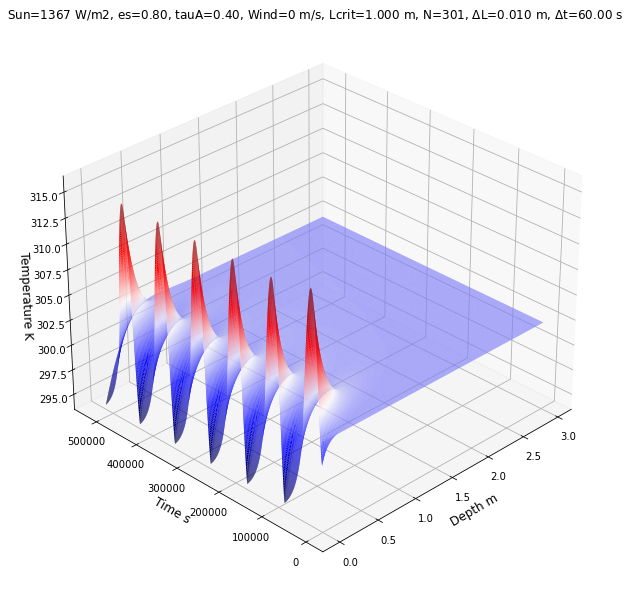

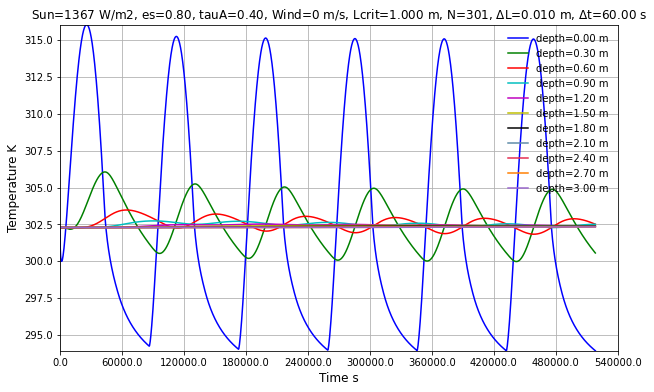

In [18]:

# get surface temperature in last 24 hours
paras['Initial value'] = T.values[0,-144:-1].mean()  # K

# time
numberDays = 6
freq =  1 / (60 * 60 * 24)
paras['numberOfTimeStep'] = numberDays * 1440
paras['deltaTime'] = 60
paras['penDepth'] = np.sqrt(7.7 * paras['diffusivity'] * paras['deltaTime'] )
totalTime = paras['numberOfTimeStep']  * paras['deltaTime'] 
t = np.linspace(0,totalTime,int(paras['numberOfTimeStep']))

valueX0 = paras['AtmoTau'] * paras['Emissivity'] * paras['Solar constant'] * np.sin(2*np.pi*t*freq)
valueX0 = np.where(valueX0>0,valueX0,0)
valueXL = 0 * np.ones(t.shape)
paras['x=0 type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=0 value'] = valueX0 
paras['x=L type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=L value'] = valueXL

print(paras)

results, cache = hc.solve(paras)

T = pp.preprocess(paras, results)


processplot(T,paras,deciX=2,deciT=5)


### Peat 40% water

In [15]:
windspeed = 0

In [16]:


column = 'values'
paras = pd.Series(name = column,dtype='object')
# paras = paras.astype('object')

# peat
paras['material'] = 'Peat 40% water'
paras['density'] = 700        #  kg/m3
paras['conductivity'] = 0.3   #  W/(m.K)
paras['heatCapacity cv'] = 3.3e6    #  J/(m3.K)
paras['heatCapacity cp'] = paras['heatCapacity cv']/paras['density']     #  J/(kg.K)
paras['diffusivity'] = paras['conductivity'] / (paras['density'] * paras['heatCapacity cp']) # m2/s
paras['penDepth (Diurnal)'] = np.sqrt(7.7 * paras['diffusivity'] * 86.4e3 )

# Solution
numberDays = 6
freq =  1 / (60 * 60 * 24)
paras['numberOfTimeStep'] = numberDays * 1440
paras['deltaTime'] = 60
paras['maxIteration'] = 20
paras['convergence'] = 1E-10
paras['relaxation'] = 1 # value in [0-1] Very sensitive!!!
paras['showProg'] = False # print every time step
paras['penDepth'] = np.sqrt(7.7 * paras['diffusivity'] * paras['deltaTime'] )


# Radiometry
paras['Do radiative'] = True
paras['Emissivity'] = 0.8
paras['AtmoTau'] = 0.4
paras['AtmoTemp'] = 298
paras['Do convection'] = True
paras['WindSpeed'] = windspeed
paras['ConvLCrit'] = 1
paras['Solar constant'] = 1367 # W/m2 top of atmo

print(paras)

material              Peat 40% water
density                          700
conductivity                     0.3
heatCapacity cv            3300000.0
heatCapacity cp          4714.285714
diffusivity                      0.0
penDepth (Diurnal)          0.245927
numberOfTimeStep                8640
deltaTime                         60
maxIteration                      20
convergence                      0.0
relaxation                         1
showProg                       False
penDepth                    0.006481
Do radiative                    True
Emissivity                       0.8
AtmoTau                          0.4
AtmoTemp                         298
Do convection                   True
WindSpeed                          0
ConvLCrit                          1
Solar constant                  1367
Name: values, dtype: object


Peat40water-L3p00-N301-T8640000-S1367-E0p80-A0p40-W0p0-Lc1p000
Sun=1367 W/m2, es=0.80, tauA=0.40, Wind=0 m/s, Lcrit=1.000 m, N=301, $\Delta$L=0.010 m, $\Delta$t=600.00 s
material                                                 Peat 40% water
density                                                             700
conductivity                                                        0.3
heatCapacity cv                                               3300000.0
heatCapacity cp                                             4714.285714
diffusivity                                                         0.0
penDepth (Diurnal)                                             0.245927
numberOfTimeStep                                                  14400
deltaTime                                                           600
maxIteration                                                         20
convergence                                                         0.0
relaxation                            

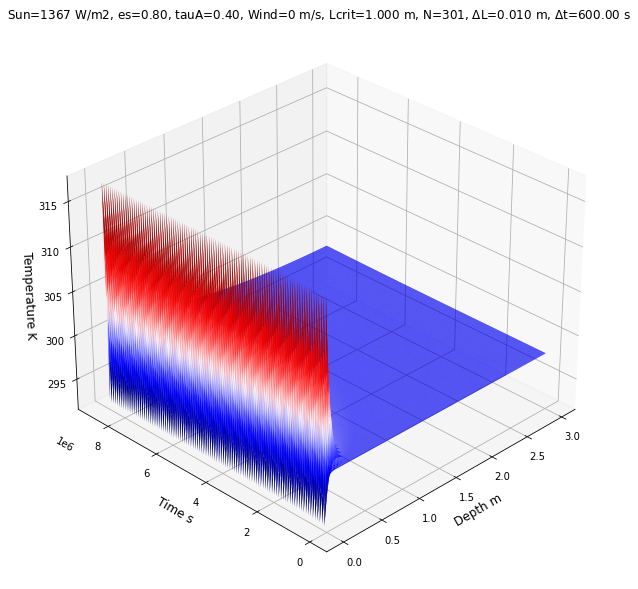

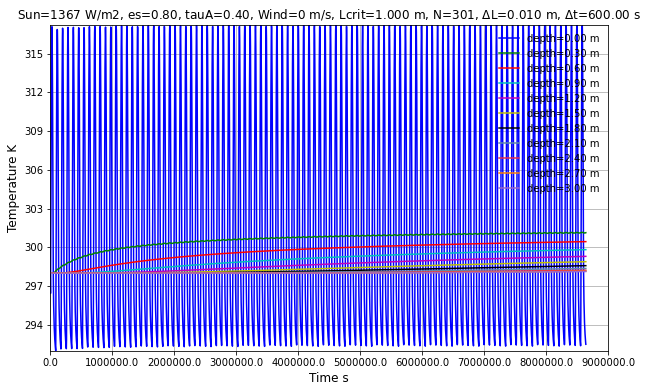

In [17]:
# Grid
paras['length'] = 3.
paras['numberOfNode'] = 301

# Initial conditions
paras['Initial value'] = 298.  # K

# time
numberDays = 100
freq =  1 / (60 * 60 * 24)
paras['numberOfTimeStep'] = numberDays * 144
paras['deltaTime'] = 600
paras['penDepth'] = np.sqrt(7.7 * paras['diffusivity'] * paras['deltaTime'] )
totalTime = paras['numberOfTimeStep']  * paras['deltaTime'] 
t = np.linspace(0,totalTime,int(paras['numberOfTimeStep']))

valueX0 = paras['AtmoTau'] * paras['Emissivity'] * paras['Solar constant'] * np.sin(2*np.pi*t*freq)
valueX0 = np.where(valueX0>0,valueX0,0)
valueXL = 0 * np.ones(t.shape)
paras['x=0 type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=0 value'] = valueX0 
paras['x=L type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=L value'] = valueXL

results, cache = hc.solve(paras)

T = pp.preprocess(paras, results)

processplot(T,paras,deciX=2,deciT=5)

paras['Temp(24h)'] = T.values[0,int(-1440*60/paras['deltaTime']):-1].mean()

print(paras)


In [18]:
paras['Temp(24h)'] = T.values[0,int(-1440*60/paras['deltaTime']):-1].mean()
print(paras)

material                                                 Peat 40% water
density                                                             700
conductivity                                                        0.3
heatCapacity cv                                               3300000.0
heatCapacity cp                                             4714.285714
diffusivity                                                         0.0
penDepth (Diurnal)                                             0.245927
numberOfTimeStep                                                  14400
deltaTime                                                           600
maxIteration                                                         20
convergence                                                         0.0
relaxation                                                            1
showProg                                                          False
penDepth                                                       0

material                                                 Peat 40% water
density                                                             700
conductivity                                                        0.3
heatCapacity cv                                               3300000.0
heatCapacity cp                                             4714.285714
diffusivity                                                         0.0
penDepth (Diurnal)                                             0.245927
numberOfTimeStep                                                   8640
deltaTime                                                            60
maxIteration                                                         20
convergence                                                         0.0
relaxation                                                            1
showProg                                                          False
penDepth                                                       0

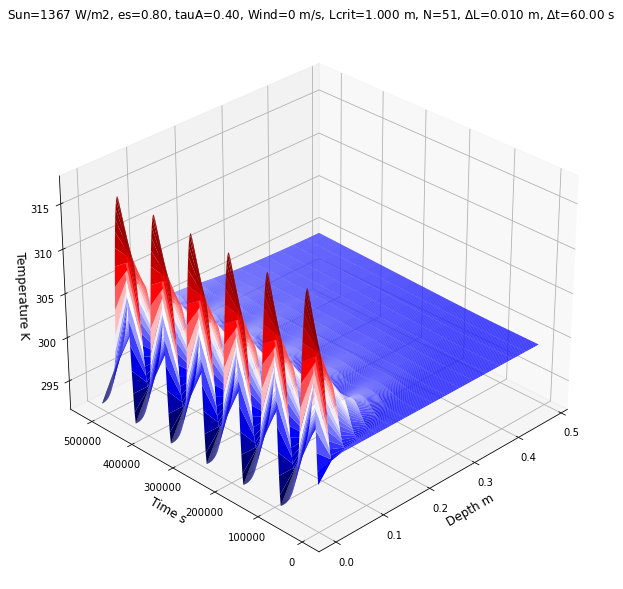

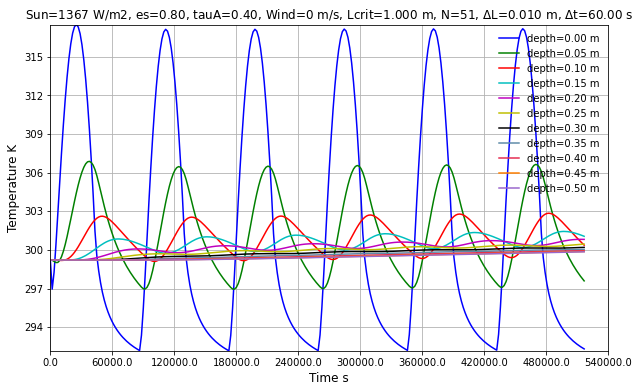

In [19]:
paras['length'] = 0.5
paras['numberOfNode'] = 51

# get surface temperature in last 24 hours
paras['Initial value'] = 299.22165  # K

# time
numberDays = 6
freq =  1 / (60 * 60 * 24)
paras['numberOfTimeStep'] = numberDays * 1440
paras['deltaTime'] = 60
paras['penDepth'] = np.sqrt(7.7 * paras['diffusivity'] * paras['deltaTime'] )
totalTime = paras['numberOfTimeStep']  * paras['deltaTime'] 
t = np.linspace(0,totalTime,int(paras['numberOfTimeStep']))

valueX0 = paras['AtmoTau'] * paras['Emissivity'] * paras['Solar constant'] * np.sin(2*np.pi*t*freq)
valueX0 = np.where(valueX0>0,valueX0,0)
valueXL = 0 * np.ones(t.shape)
paras['x=0 type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=0 value'] = valueX0 
paras['x=L type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=L value'] = valueXL

print(paras)

results, cache = hc.solve(paras)

T = pp.preprocess(paras, results)
Thinum = T
hinum = paras['numberOfNode'] 

processplot(T,paras,deciX=3,deciT=30)


## Investigate the effect of number of nodes

Do the simulation with different number of depth nodes and observe the results.



In [20]:
# to set up peat general conditions
column = 'values'
paras = pd.Series(name = column,dtype='object')
# paras = paras.astype('object')

# Grid
paras['length'] = 0.246
paras['numberOfNode'] = 10

# peat
paras['material'] = 'Peat 40% water'
paras['density'] = 700        #  kg/m3
paras['conductivity'] = 0.3   #  W/(m.K)
paras['heatCapacity cv'] = 3.3e6    #  J/(m3.K)
paras['heatCapacity cp'] = paras['heatCapacity cv']/paras['density']     #  J/(kg.K)
paras['diffusivity'] = paras['conductivity'] / (paras['density'] * paras['heatCapacity cp']) # m2/s
paras['penDepth (Diurnal)'] = np.sqrt(7.7 * paras['diffusivity'] * 86.4e3 )

# Solution
freq =  1 / (60 * 60 * 24)
paras['deltaTime'] = 60
paras['maxIteration'] = 20
paras['convergence'] = 1E-10
paras['relaxation'] = 1 # value in [0-1] Very sensitive!!!
paras['showProg'] = False # print every time step
paras['penDepth'] = np.sqrt(7.7 * paras['diffusivity'] * paras['deltaTime'] )

# Radiometry
paras['Do radiative'] = True
paras['Emissivity'] = 0.8
paras['AtmoTau'] = 0.4
paras['AtmoTemp'] = 298
paras['Do convection'] = True
paras['WindSpeed'] = windspeed
paras['ConvLCrit'] = 1
paras['Solar constant'] = 1367 # W/m2 top of atmo

######################################################################
# Set up the run with starting temperature at end of 100 days from previous run
if paras['WindSpeed'] == 0:
    paras['Initial value'] = 301.944889 # K 
elif paras['WindSpeed'] == 10:
    paras['Initial value'] = 299.22165 # K 
else:
    print('************************* no value for wind speed ********************')

numberDays = 6
paras['numberOfTimeStep'] = numberDays * 1440
totalTime = (paras['numberOfTimeStep'] + 1) * paras['deltaTime'] 
t = np.linspace(0,totalTime,int(paras['numberOfTimeStep']))

valueX0 = paras['AtmoTau'] * paras['Emissivity'] * paras['Solar constant'] * np.sin(2*np.pi*t*freq)
valueX0 = np.where(valueX0>0,valueX0,0)
valueXL = 0 * np.ones(t.shape)
paras['x=0 type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=0 value'] = valueX0 
paras['x=L type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=L value'] = valueXL
    
# loop through nodes
dicT = {}
for ino,NoNodes in enumerate(range(3,12)):
    paras['numberOfNode'] = NoNodes
    if ino==0:
        print(paras)
    print(f"Number of nodes {paras['numberOfNode']}")

    results, cache = hc.solve(paras)
    T = pp.preprocess(paras, results)
    dicT[NoNodes] = T

dicT[hinum] = Thinum

length                                                            0.246
numberOfNode                                                          3
material                                                 Peat 40% water
density                                                             700
conductivity                                                        0.3
heatCapacity cv                                               3300000.0
heatCapacity cp                                             4714.285714
diffusivity                                                         0.0
penDepth (Diurnal)                                             0.245927
deltaTime                                                            60
maxIteration                                                         20
convergence                                                         0.0
relaxation                                                            1
showProg                                                        

Peat40water-nodecompare-L0p25-T518460-S1367-E0p80-A0p40-W0p0-Lc1p000


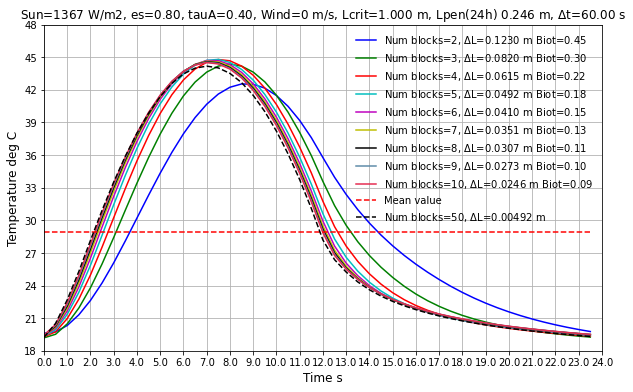

In [21]:
q = ryplot.Plotter(1,1,1,figsize=(10,6),doWarning=False)
Tmin = 1e6
Tmax = 0
scenarioa = f"Sun={paras['Solar constant']:.0f} W/m2, es={paras['Emissivity']:.2f}, tauA={paras['AtmoTau']:.2f}, "
scenariob = f"Wind={paras['WindSpeed']:.0f} m/s, Lcrit={paras['ConvLCrit']:.3f} m, "
scenarioc = f"Lpen(24h)={paras['penDepth (Diurnal)']:.3f} m, $\Delta$t={paras['deltaTime']:.2f} s"
scenario = f"{scenarioa}{scenariob}{scenarioc}"

for key in dicT.keys():
    deltaL = paras['length']/(key-1)
    deciT = 30
    lastDay = int(paras['deltaTime'] * 60 * 24 / (2 * deciT))
    df = dicT[key].loc[0,:]
    samples = df.values[-lastDay::deciT] -273
    times = np.asarray(dicT[key].columns[-lastDay::deciT])
    times = (times - np.min(times)) / (60*60)
    
    
    # Set up the run with starting temperature at end of 100 days from previous run
    if paras['WindSpeed'] == 0:
        Tmin = 18  #np.min(samples) if np.min(samples) < Tmin else Tmin
        Tmax = 48  #np.max(samples) if np.max(samples) > Tmax else Tmax
    elif paras['WindSpeed'] == 10:
        Tmin = 23  #np.min(samples) if np.min(samples) < Tmin else Tmin
        Tmax = 33  #np.max(samples) if np.max(samples) > Tmax else Tmax
    else:
        print('************************* no value for wind speed ********************')

    if key < 50:
        q.plot(1,times,samples,'','Time s','Temperature deg C',
               pltaxis=[0,24,Tmin,Tmax],label=[f'Num blocks={key-1}, $\Delta$L={deltaL:.4f} m Biot={0.1*8.9/(key-1):.2f}'])
    else:
        q.plot(1,times,paras['Initial value']*np.ones(times.shape)-273,scenario,'Time s','Temperature deg C',maxNX=24,
               pltaxis=[0,24,Tmin,Tmax],plotCol='r',
               label=[f'Mean value' ],linestyle='--')

        q.plot(1,times,samples,scenario,'Time s','Temperature deg C',maxNX=24,
               pltaxis=[0,24,Tmin,Tmax],plotCol='k',
               label=[f'Num blocks={key-1}, $\Delta$L={deltaL:.5f} m' ],linestyle='--')
    
filenamea = f"{paras['material']}-nodecompare-L{paras['length']:.2f}"
filenameb = f"-T{totalTime:.0f}-S{paras['Solar constant']:.0f}"
filenamec = f"-E{paras['Emissivity']:.2f}-A{paras['AtmoTau']:.2f}-W{paras['WindSpeed']:.1f}-Lc{paras['ConvLCrit']:.3f}"
filename = f"{filenamea}{filenameb}{filenamec}".replace(' ','').replace('%','').replace('.','p')
print(filename)
q.saveFig(f'{filename}.png')    

## Investigate the node size

Keep the number of nodes at 2, but increase the depth of the nodes

In [58]:
# to set up peat general conditions
column = 'values'
paras = pd.Series(name = column,dtype='object')
# paras = paras.astype('object')

# Grid
paras['length'] = 0.246
paras['numberOfNode'] = 7

# peat
paras['material'] = 'Peat 40% water'
paras['density'] = 700        #  kg/m3
paras['conductivity'] = 0.3   #  W/(m.K)
paras['heatCapacity cv'] = 3.3e6    #  J/(m3.K)
paras['heatCapacity cp'] = paras['heatCapacity cv']/paras['density']     #  J/(kg.K)
paras['diffusivity'] = paras['conductivity'] / (paras['density'] * paras['heatCapacity cp']) # m2/s
paras['penDepth (Diurnal)'] = np.sqrt(7.7 * paras['diffusivity'] * 86.4e3 )

# Solution
freq =  1 / (60 * 60 * 24)
paras['deltaTime'] = 60
paras['maxIteration'] = 20
paras['convergence'] = 1E-10
paras['relaxation'] = 1 # value in [0-1] Very sensitive!!!
paras['showProg'] = False # print every time step
paras['penDepth'] = np.sqrt(7.7 * paras['diffusivity'] * paras['deltaTime'] )

# Radiometry
paras['Do radiative'] = True
paras['Emissivity'] = 0.8
paras['AtmoTau'] = 0.4
paras['AtmoTemp'] = 298
paras['Do convection'] = True
paras['WindSpeed'] = windspeed
paras['ConvLCrit'] = 1
paras['Solar constant'] = 1367 # W/m2 top of atmo

######################################################################
# Set up the run with starting temperature at end of 100 days from previous run
if paras['WindSpeed'] == 0:
    paras['Initial value'] = 301.944889 # K 
elif paras['WindSpeed'] == 10:
    paras['Initial value'] = 299.22165 # K 
else:
    print('************************* no value for wind speed ********************')

numberDays = 6
paras['numberOfTimeStep'] = numberDays * 1440
totalTime = (paras['numberOfTimeStep'] + 1) * paras['deltaTime'] 
t = np.linspace(0,totalTime,int(paras['numberOfTimeStep']))

valueX0 = paras['AtmoTau'] * paras['Emissivity'] * paras['Solar constant'] * np.sin(2*np.pi*t*freq)
valueX0 = np.where(valueX0>0,valueX0,0)
valueXL = 0 * np.ones(t.shape)
paras['x=0 type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=0 value'] = valueX0 
paras['x=L type'] = 'heatFlux'#'heatFlux' W/m2  or 'fixedTemperature' K
paras['x=L value'] = valueXL
    
# loop through block sizes
dicL = {}
for ino,length in enumerate(0.246 * np.linspace(0.1,1,10)):
    paras['length'] = length
    if ino==0:
        print(paras)
    print(f"length {paras['length']}")

    results, cache = hc.solve(paras)
    T = pp.preprocess(paras, results)
    dicL[length] = T

dicL[hinum] = Thinum

length                                                           0.0246
numberOfNode                                                        7.0
material                                                 Peat 40% water
density                                                             700
conductivity                                                        0.3
heatCapacity cv                                               3300000.0
heatCapacity cp                                             4714.285714
diffusivity                                                         0.0
penDepth (Diurnal)                                             0.245927
deltaTime                                                            60
maxIteration                                                         20
convergence                                                         0.0
relaxation                                                            1
showProg                                                        

Peat40water-nodecompare-N7p00-T518460-S1367-E0p80-A0p40-W0p0-Lc1p000


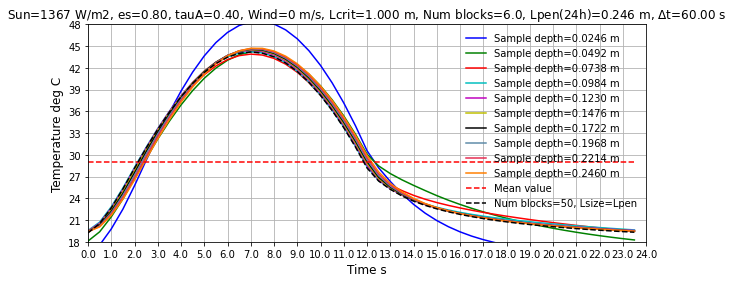

In [60]:
q = ryplot.Plotter(1,1,1,figsize=(10,4),doWarning=False)
Tmin = 1e6
Tmax = 0
scenarioa = f"Sun={paras['Solar constant']:.0f} W/m2, es={paras['Emissivity']:.2f}, tauA={paras['AtmoTau']:.2f}, "
scenariob = f"Wind={paras['WindSpeed']:.0f} m/s, Lcrit={paras['ConvLCrit']:.3f} m, "
scenarioc = f"Num blocks={paras['numberOfNode']-1}, Lpen(24h)={paras['penDepth (Diurnal)']:.3f} m, $\Delta$t={paras['deltaTime']:.2f} s"
scenario = f"{scenarioa}{scenariob}{scenarioc}"

for key in dicL.keys():
    Lsize = key
    deciT = 30
    lastDay = int(paras['deltaTime'] * 60 * 24 / (2 * deciT))
    df = dicL[key].loc[0,:]
    samples = df.values[-lastDay::deciT] -273
    times = np.asarray(dicL[key].columns[-lastDay::deciT])
    times = (times - np.min(times)) / (60*60)
    
    # Set up the run with starting temperature at end of 100 days from previous run
    if paras['WindSpeed'] == 0:
        Tmin = 18  #np.min(samples) if np.min(samples) < Tmin else Tmin
        Tmax = 48  #np.max(samples) if np.max(samples) > Tmax else Tmax
    elif paras['WindSpeed'] == 10:
        Tmin = 23  #np.min(samples) if np.min(samples) < Tmin else Tmin
        Tmax = 33  #np.max(samples) if np.max(samples) > Tmax else Tmax
    else:
        print('************************* no value for wind speed ********************')

    if key < 50:
        q.plot(1,times,samples,'','Time s','Temperature deg C',
               pltaxis=[0,24,Tmin,Tmax],label=[f"Sample depth={Lsize:.4f} m"])
    else:
        q.plot(1,times,paras['Initial value']*np.ones(times.shape)-273,scenario,'Time s','Temperature deg C',
               maxNX=24,
               pltaxis=[0,24,Tmin,Tmax],plotCol='r',
               label=[f'Mean value' ],linestyle='--')

        q.plot(1,times,samples,scenario,'Time s','Temperature deg C',maxNX=24,
               pltaxis=[0,24,Tmin,Tmax],plotCol='k',
               label=[f'Num blocks={key-1}, Lsize=Lpen' ],linestyle='--')
    
filenamea = f"{paras['material']}-nodecompare-N{paras['numberOfNode']:.2f}"
filenameb = f"-T{totalTime:.0f}-S{paras['Solar constant']:.0f}"
filenamec = f"-E{paras['Emissivity']:.2f}-A{paras['AtmoTau']:.2f}-W{paras['WindSpeed']:.1f}-Lc{paras['ConvLCrit']:.3f}"
filename = f"{filenamea}{filenameb}{filenamec}".replace(' ','').replace('%','').replace('.','p')
print(filename)
q.saveFig(f'{filename}.png')    